# Answering Business Questions Using SQL
## *Chinook Database SQLite*
In this guided project from [Dataquest.io](https://dataquest.io), I will be writing SQL queries, creating plots, and explaining the data based on the given business questions.

In [4]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

sns.set(style="white", palette="Set2")

def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = ('SELECT name, type FROM sqlite_master WHERE type IN ("table","view");')
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Question 1: Chinook record store has signed a deal with a record label; find out which genres sell the most tracks in the USA and create a visualization of those findings.

In [5]:
q1 = (
    '''
    WITH tracks_usa AS (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA")
    
    SELECT
    g.name genre,
    COUNT(tu.invoice_line_id) absolute,
    cast(COUNT(tu.invoice_line_id) AS float)/ (SELECT COUNT(*) FROM tracks_usa) percent
    FROM tracks_usa tu
    INNER JOIN track t ON t.track_id = tu.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
    ''')
run_query(q1)

,genre,absolute,percent
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


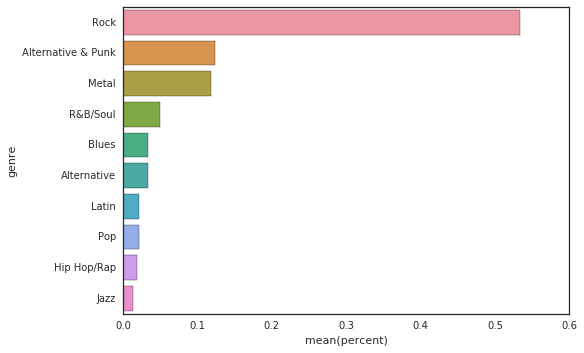

In [6]:
top_usa = run_query(q1)

with sns.color_palette("BuGn_r"):
    sns.barplot(x="percent", y="genre", data=top_usa, orient="h")

Based on the top ten genres, we would want to purchase the albums from:
* Red Tone, as Alternative & Punk is the number two genre
* Slim Jim Bites, as Blues is fifth
* Meteor and the Girls, in eighth

### Question 2: Find the total dollar amount of sales assigned to each support agent within the company and plot the results.

In [7]:
q2 = (
    '''
    SELECT
    e.first_name || " " || e.last_name employee_name,
    e.hire_date,
    SUM(i.total) total_sales
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY e.employee_id
    '''
    )
run_query(q2)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


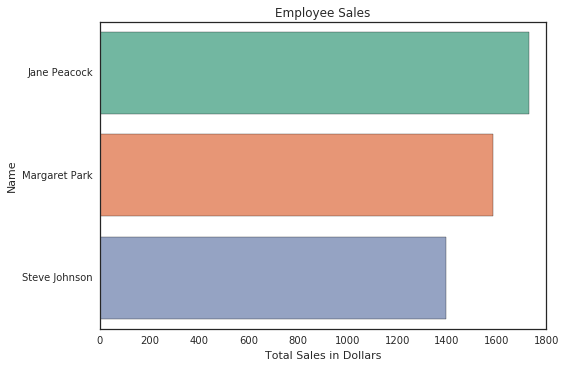

In [8]:
e_sales = run_query(q2)
sns.barplot(x="total_sales", y="employee_name", data=e_sales, orient="h")
plt.title("Employee Sales")
plt.xlabel("Total Sales in Dollars")
plt.ylabel("Name")

While Steve Johnson has the lowest sales numbers, we can see from the results of the query that he was hired later than the other employees, which excuses him.

### Question 3: Calculate, per country, the:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value <br/>
_Where a country has only one customer, collect them into an "Other" group._  
Sort the results from highest total sales to lowest, with "Other" at the bottom.

In [9]:
# this command assigns a country of "Other" to countries with only one customer
qt = '''
     CREATE VIEW other_assignment AS
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     '''
run_command(qt)

OperationalError: table other_assignment already exists

In [10]:
q3a = '''
SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     LIMIT 5
'''
run_query(q3a)

,country,customer_id,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,USA,18,1,1,1158,0.99,1
1,USA,18,2,1,1159,0.99,1
2,USA,18,3,1,1160,0.99,1
3,USA,18,4,1,1161,0.99,1
4,USA,18,5,1,1162,0.99,1


Above we can see the output of the view we created.

In [11]:
q3 = (
    '''
    SELECT
        country,
        total_customers,
        total_sales,
        average_sales_per_customer,
        average_order
    FROM
    (
        SELECT 
            country,
            COUNT(DISTINCT customer_id) total_customers,
            SUM(unit_price) total_sales,
            ROUND(SUM(unit_price) / COUNT(DISTINCT customer_id), 2) average_sales_per_customer,
            ROUND(SUM(unit_price) / COUNT(DISTINCT invoice_id), 2) average_order,
            CASE
                WHEN country = "Other" THEN 1
                ELSE 0
            END AS sort
        FROM other_assignment oa
        GROUP BY 1
        ORDER BY sort ASC, 3 DESC
    )
    ''')
run_query(q3)

,country,total_customers,total_sales,average_sales_per_customer,average_order
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.58,8.72
9,Other,15,1094.94,73.00,7.45


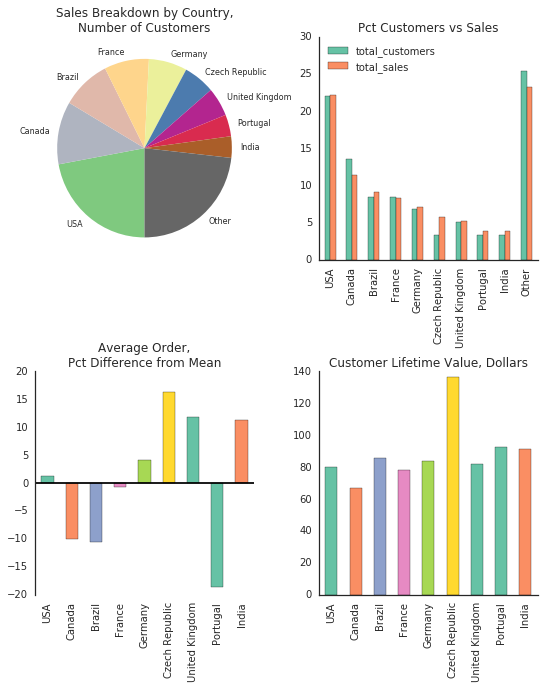

In [12]:
by_country = run_query(q3)
by_country.set_index("country", inplace=True, drop=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left
sales_breakdown = by_country["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["total_customers","total_sales"]
custs_vs_dollars = by_country[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = by_country["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = by_country["average_sales_per_customer"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

#### Interpretations
It is interesting to note that the Czech Republic has the highest total spending per customer and the highest average order total. There are two possible interpretations: one, that Czech customers are valuable in general and that expanding there would be worthwhile; or two, that other countries are just behind, and effort should be spending increasing spending on a per-customer basis to the Czech levels.  
_Another thing to note: there are not that many sales overall, so the sample size is rather limited. It would not be prudent to launch large campaigns based on this data._  
That being said, I would recommend a closer look at implementing pilot campaigns in Czechia, United Kingdom, and India in the hopes of capitalizing on those larger average orders and attempting to expand total orders and total customers.

### Question 4: Categorize each invoice as either album purchase or not, calculating:
* Number of invoices
* Percentage of invoices

In [13]:
q4 = '''
    WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
    '''
run_query(q4)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


#### Final Results
This was a very difficult final question (regarding the EXCEPT and IS NULL CASE), but the output supports the idea that a non-trivial amount of purchases are full album purchases and should not be ignored.

#### Further Questions:
* Which artist is used in the most playlists?
* How many tracks have been purchases vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?
* Do protected vs non-protected media types have an effect on popularity?